<a href="https://colab.research.google.com/github/hayeong0206/25-1/blob/main/lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 구조 및 전처리 코드

## 1. 데이터 구조 파악
- train.csv: 22,200행 × 49열 (id + 46개의 입력 변수 + shares + y)
- test.csv: 9,515행 × 47열 (id + 46개의 입력 변수)
- target(y): 0과 1이 거의 균형

## 2. 결측치 비율 확인
- 모든 변수에 약 10% 내외의 결측치 존재

## 3. 변수 유형
특성변수
- 수치형 변수: 대부분 float64
- 범주형 변수: `data_channel`, `weekday` (object)

목표변수
-수치형 변수 : 'shares', int64
-범주형 변수 : 'y', int64 (0,1로 이루어진 이진범주형 변수)

## 4. 전처리 방법
- 수치형 변수: 평균 대체 후 StandardScaler로 정규화
- 범주형 변수: 최빈값 대체 후 OneHotEncoder 인코딩
- 전처리 후 feature 수: 57개 (train: (22200, 57), test: (9515, 57))

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os
root_dir="/content/gdrive/MyDrive/패턴인식"
#각자 자료 저장한 루트로 수정
os.path.exists(root_dir)

True

In [3]:
import pandas as pd

data_path_train=os.path.join(root_dir,"train.csv")
data_path_test=os.path.join(root_dir,"test.csv")

train_df = pd.read_csv(data_path_train)
test_df = pd.read_csv(data_path_test)

print(train_df.shape)
print(test_df.shape)
train_df.info()
print(train_df['y'].value_counts(normalize=True))

(22200, 49)
(9515, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            22200 non-null  int64  
 1   n_tokens_title                20000 non-null  float64
 2   n_tokens_content              20054 non-null  float64
 3   n_unique_tokens               19942 non-null  float64
 4   n_non_stop_words              20017 non-null  float64
 5   n_non_stop_unique_tokens      19944 non-null  float64
 6   num_hrefs                     19967 non-null  float64
 7   num_self_hrefs                19920 non-null  float64
 8   num_imgs                      19986 non-null  float64
 9   num_videos                    19906 non-null  float64
 10  average_token_length          19987 non-null  float64
 11  num_keywords                  19955 non-null  float64
 12  kw_min_min                    19984 n

In [4]:
# 결측치 비율
train_df.isnull().mean().sort_values(ascending=False).head(46)

,0
num_videos,0.103333
avg_negative_polarity,0.102883
num_self_hrefs,0.102703
min_negative_polarity,0.102432
title_subjectivity,0.102342
abs_title_subjectivity,0.102072
n_unique_tokens,0.101712
n_non_stop_unique_tokens,0.101622
global_subjectivity,0.101532
global_rate_negative_words,0.101306


In [6]:
test_df.isnull().mean().sort_values(ascending=False).head(10)

,0
num_videos,0.108250
max_negative_polarity,0.106779
self_reference_max_shares,0.105202
LDA_02,0.105202
abs_title_sentiment_polarity,0.104677
LDA_03,0.104362
min_positive_polarity,0.102680
average_token_length,0.102470
kw_avg_avg,0.102470
n_tokens_content,0.102470


In [5]:
# 전처리
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_cols = [col for col in train_df.select_dtypes(include=['float64', 'int64']).columns
                 if col not in ['id', 'shares', 'y']]
categorical_cols = ['data_channel', 'weekday']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    # 5-Fold Stratified Cross-Validation에서 계속 error가 생겨서 sparse_output=False 추가함.
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train = train_df.drop(columns=['id', 'shares', 'y'])
y_train = train_df['y']
X_test = test_df.drop(columns=['id'])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((22200, 57), (9515, 57))

# 전처리 분석


라이브러리 임포트

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

Split the data into training & test sets.

In [8]:
X = train_df.drop(columns=['id', 'shares', 'y'])
y = train_df['y']
X_test = test_df.drop(columns=['id'])

Train/Hold-out 분할 (Hold-out: 25%)

In [9]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("▶ Train shape:", X_train.shape)
print("▶ Hold-out    shape:", X_holdout.shape)

▶ Train shape: (16650, 46)
▶ Hold-out    shape: (5550, 46)


전처기(Preprocessor) 학습(fit) 및 변환(transform)

In [10]:
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_holdout_proc    = preprocessor.transform(X_holdout)
X_test_proc       = preprocessor.transform(X_test)

print("▶ Processed Train full:", X_train_proc.shape)
print("▶ Processed Hold-out: ", X_holdout_proc.shape)
print("▶ Processed Test:     ", X_test_proc.shape)

▶ Processed Train full: (16650, 57)
▶ Processed Hold-out:  (5550, 57)
▶ Processed Test:      (9515, 57)


분석용 DataFrame 생성

In [11]:
num_features = numerical_cols
cat_features = preprocessor \
    .named_transformers_['cat']['encoder'] \
    .get_feature_names_out(categorical_cols) \
    .tolist()
feature_names = num_features + cat_features

import pandas as pd
df_train_proc = pd.DataFrame(X_train_proc, columns=feature_names)

In [12]:
# 전처리된 데이터 기본 정보 확인
print("\n▶ Processed Train Info:")
df_train_proc.info()


▶ Processed Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16650 entries, 0 to 16649
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                16650 non-null  float64
 1   n_tokens_content              16650 non-null  float64
 2   n_unique_tokens               16650 non-null  float64
 3   n_non_stop_words              16650 non-null  float64
 4   n_non_stop_unique_tokens      16650 non-null  float64
 5   num_hrefs                     16650 non-null  float64
 6   num_self_hrefs                16650 non-null  float64
 7   num_imgs                      16650 non-null  float64
 8   num_videos                    16650 non-null  float64
 9   average_token_length          16650 non-null  float64
 10  num_keywords                  16650 non-null  float64
 11  kw_min_min                    16650 non-null  float64
 12  kw_max_min                    16650

In [13]:
# 수치형 변수 요약 통계
print("\n▶ Numeric Summary:")
display(df_train_proc[num_features].describe().T)


▶ Numeric Summary:


,count,mean,std,min,25%,50%,75%,max
n_tokens_title,16650.0,6.842441e-16,1.00003,-3.682882,-0.691918,8.855033e-16,8.035640e-01,4.293022
n_tokens_content,16650.0,1.482965e-17,1.00003,-1.242991,-0.642803,-2.006799e-01,2.780961e-01,15.738668
n_unique_tokens,16650.0,2.209511e-16,1.00003,-3.999827,-0.383005,0.000000e+00,5.278522e-01,3.546305
n_non_stop_words,16650.0,-3.535644e-16,1.00003,-5.877256,0.189027,1.890275e-01,1.890275e-01,0.189027
n_non_stop_unique_tokens,16650.0,1.143696e-16,1.00003,-4.543905,-0.256296,3.549710e-02,4.943630e-01,2.214048
num_hrefs,16650.0,3.723415e-17,1.00003,-1.025948,-0.550264,-2.648537e-01,1.156936e-01,15.242445
num_self_hrefs,16650.0,-1.864908e-16,1.00003,-0.899675,-0.625517,-7.720241e-02,1.969550e-01,19.387976
num_imgs,16650.0,8.001607e-17,1.00003,-0.579122,-0.449463,-4.494632e-01,1.151599e-16,13.423996
num_videos,16650.0,-1.642997e-17,1.00003,-0.316566,-0.316566,-3.165661e-01,-6.163053e-02,22.882574
average_token_length,16650.0,-6.736287e-16,1.00003,-5.592811,-0.055382,9.665759e-02,3.518145e-01,4.302616


<ipython-input-14-4040cbce00ac>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


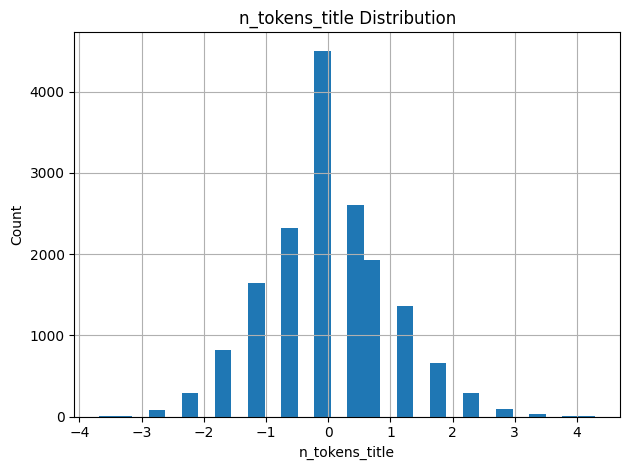

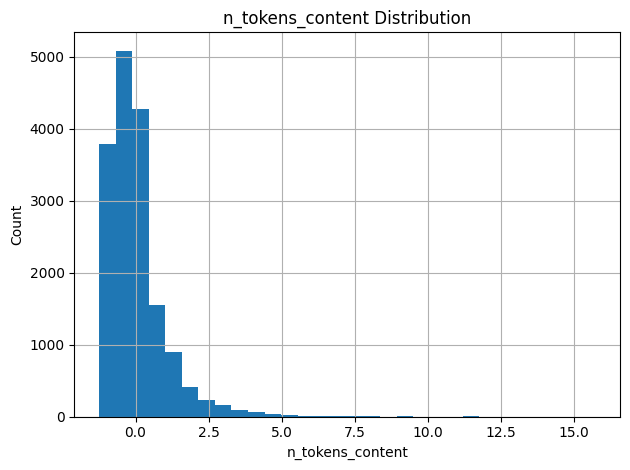

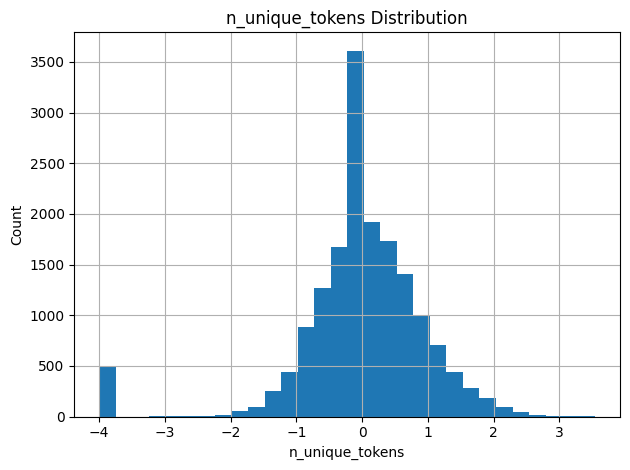

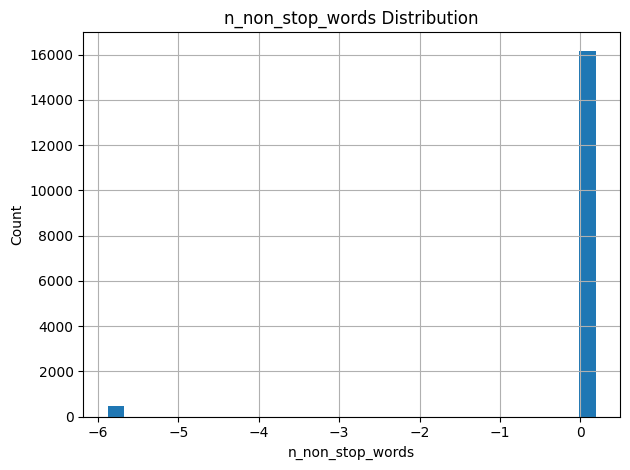

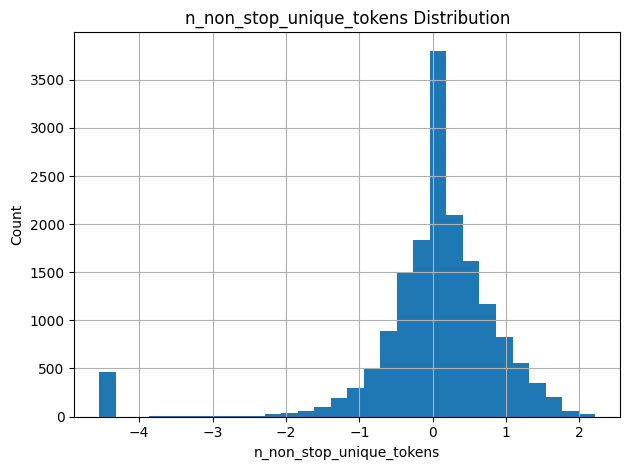

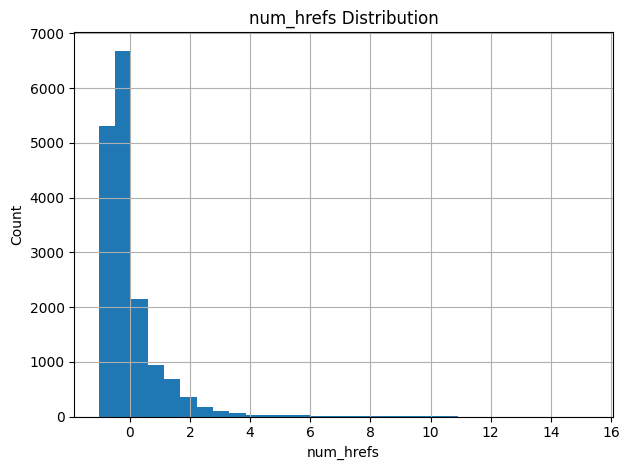

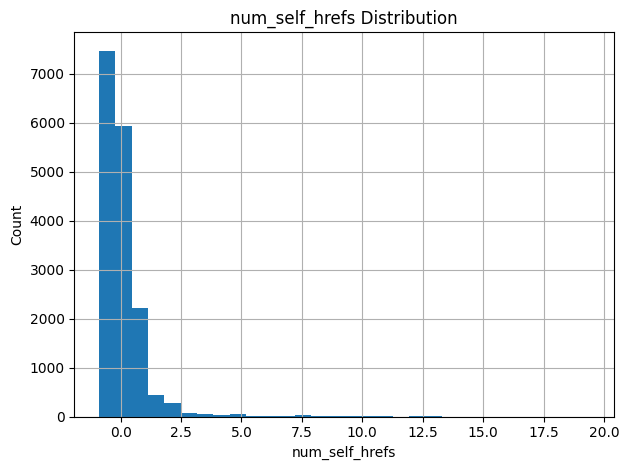

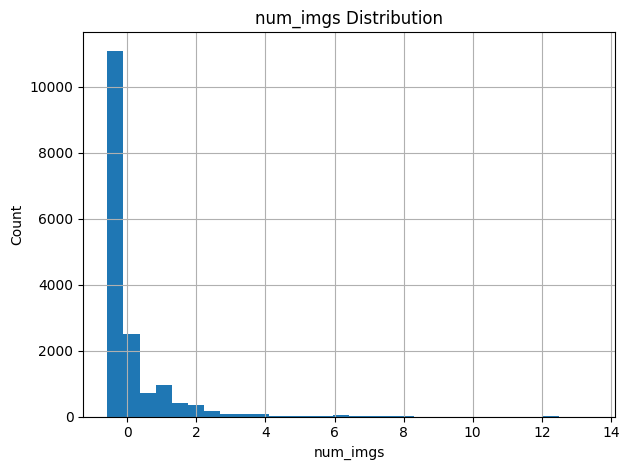

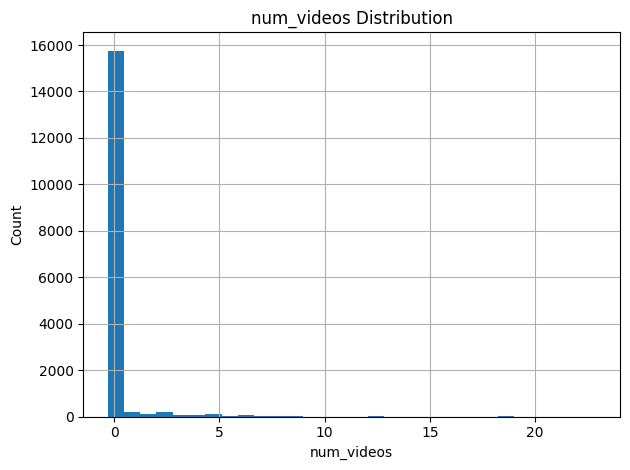

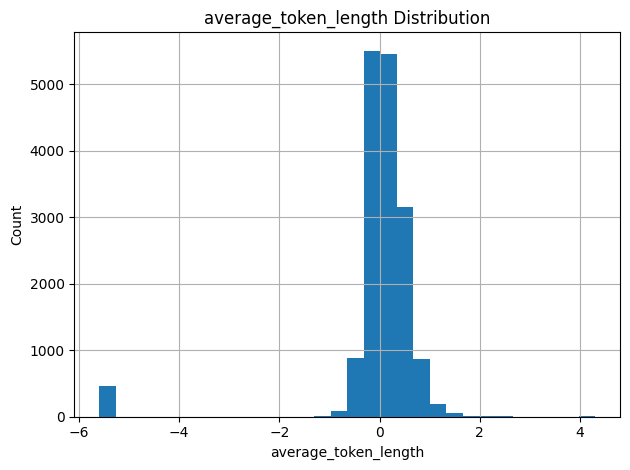

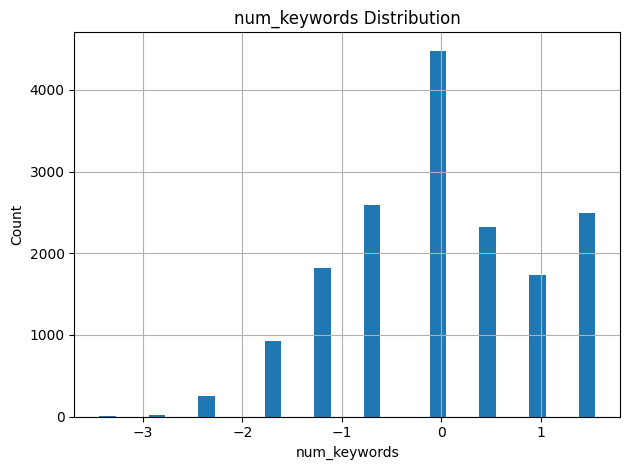

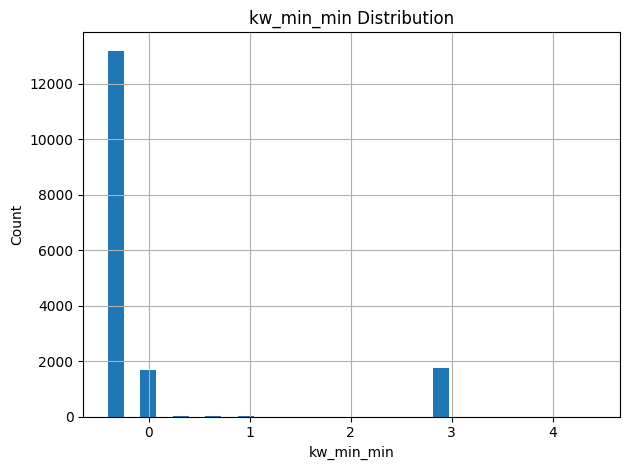

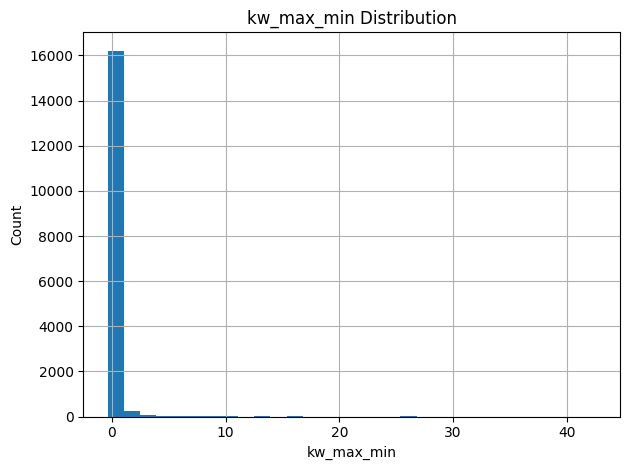

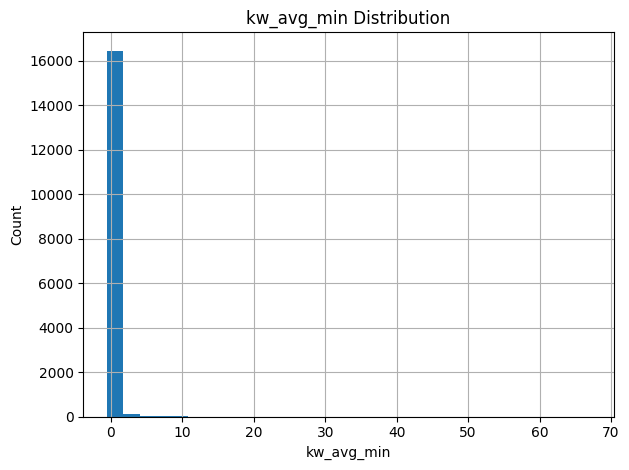

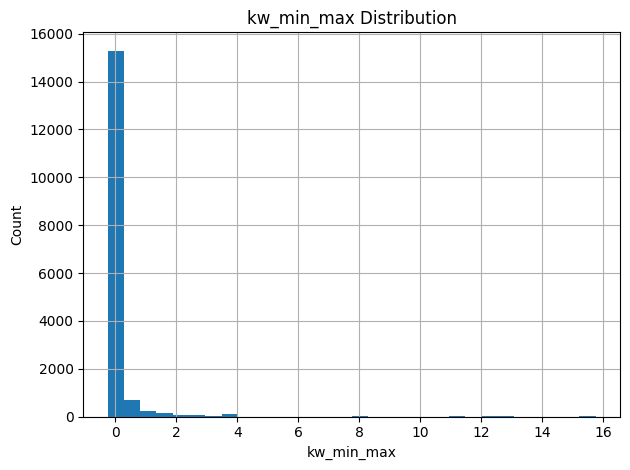

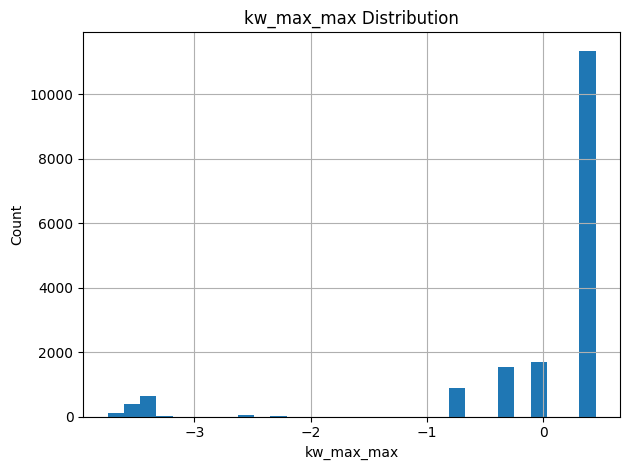

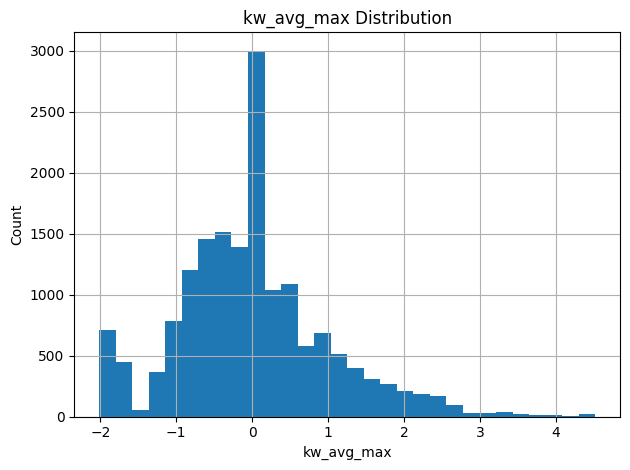

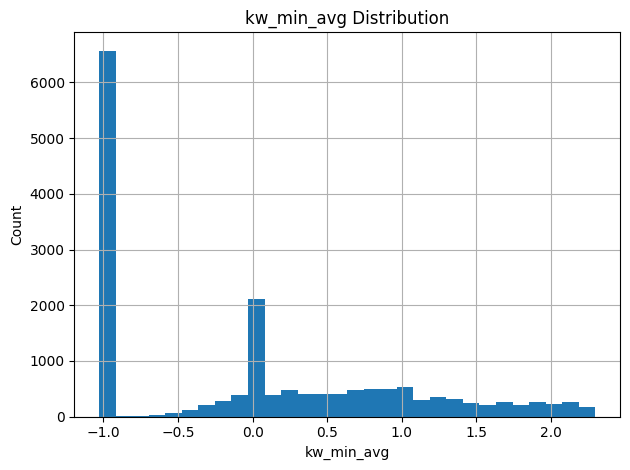

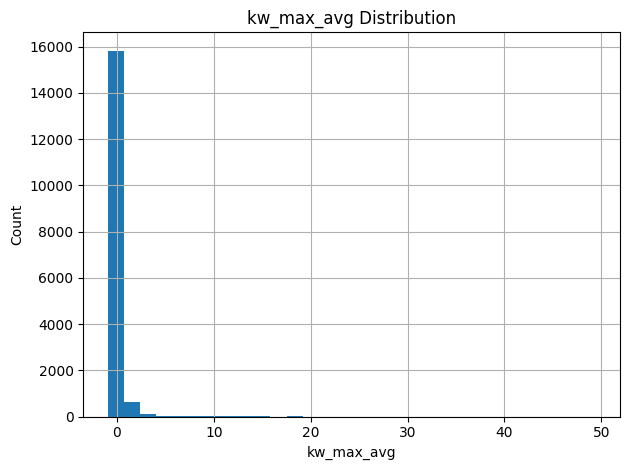

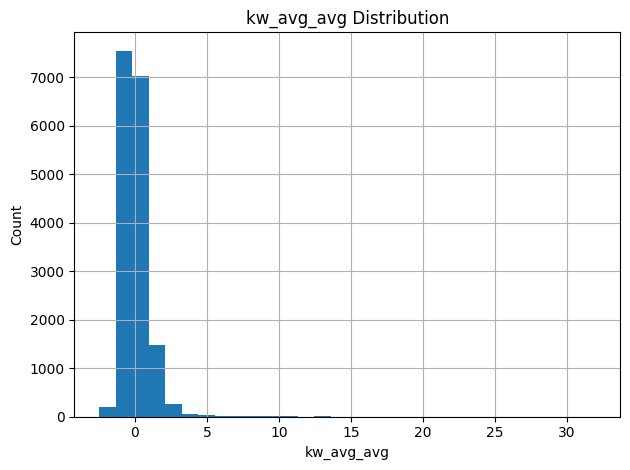

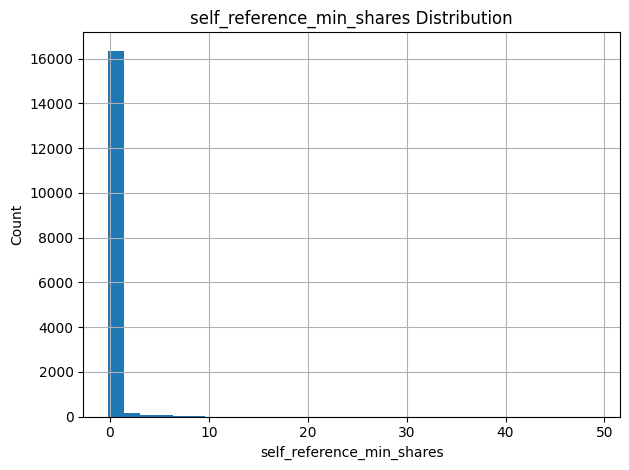

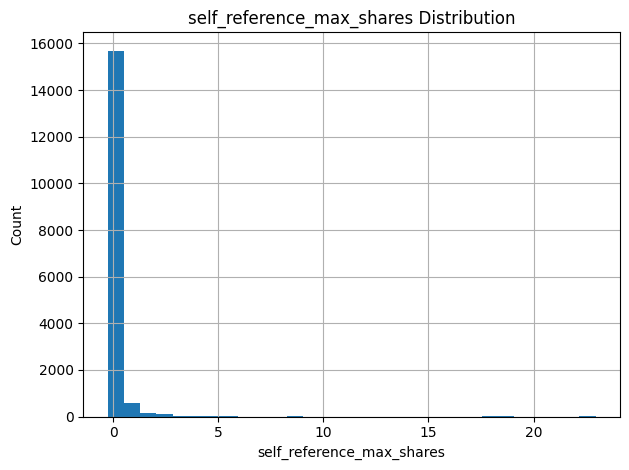

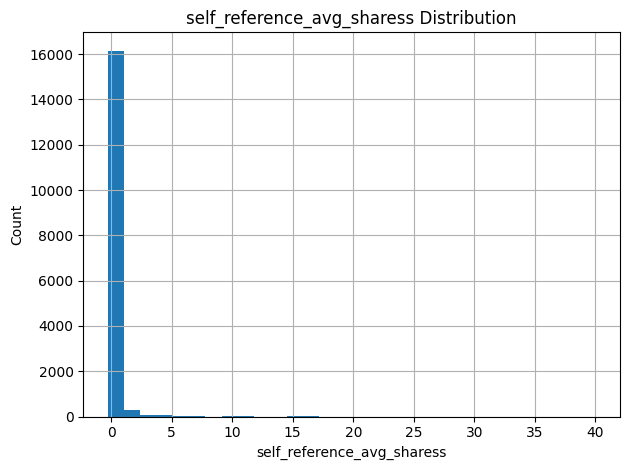

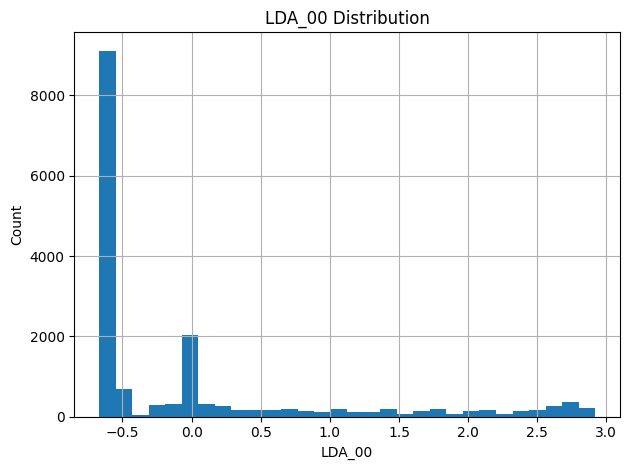

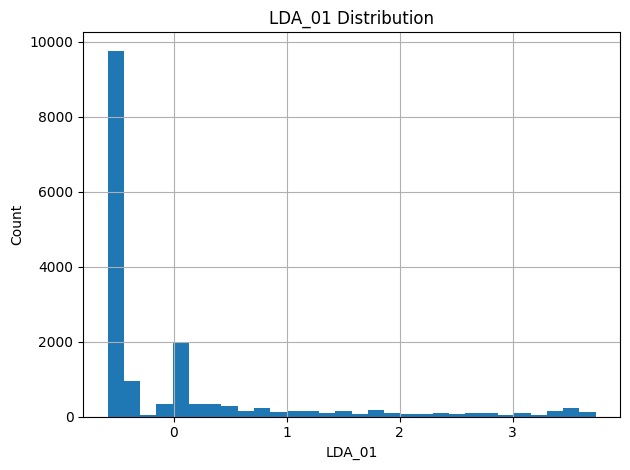

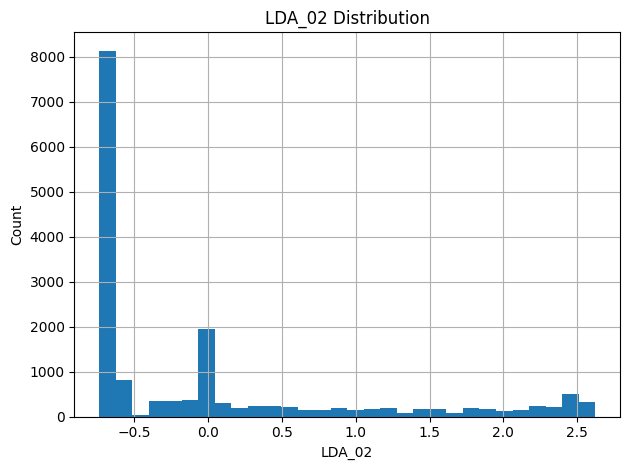

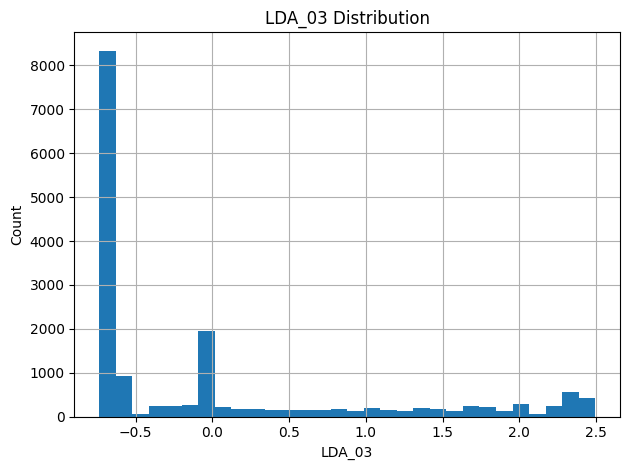

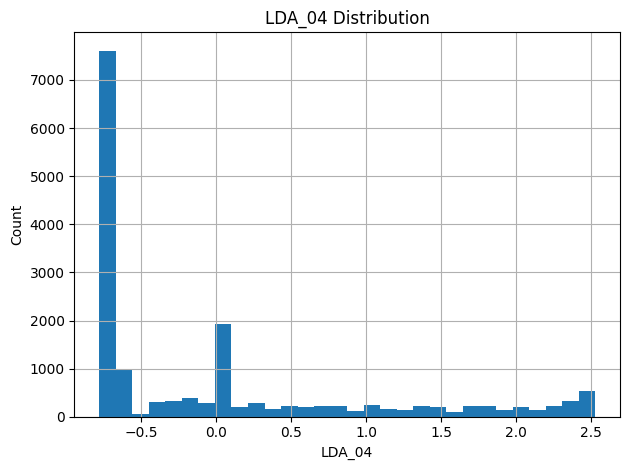

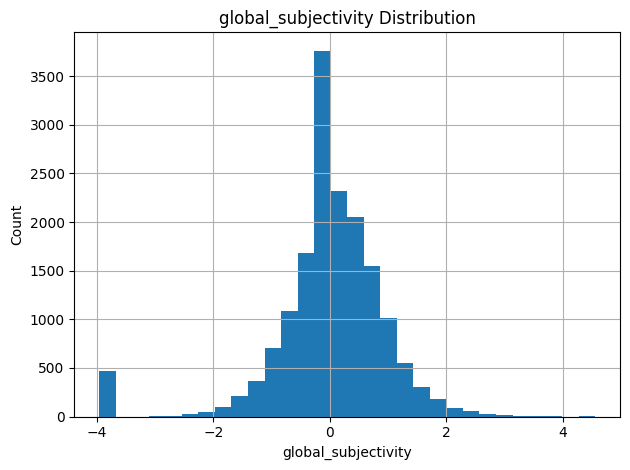

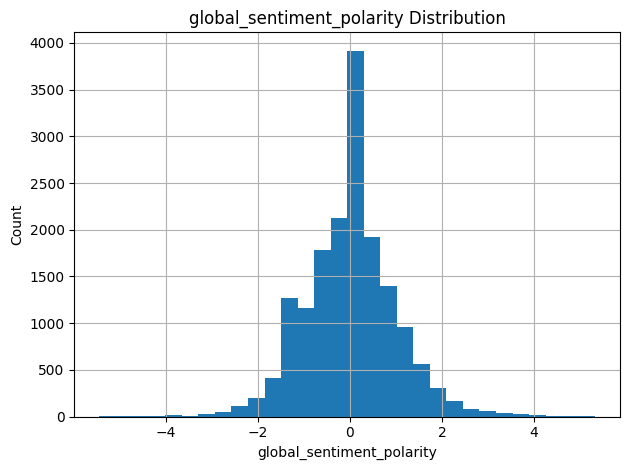

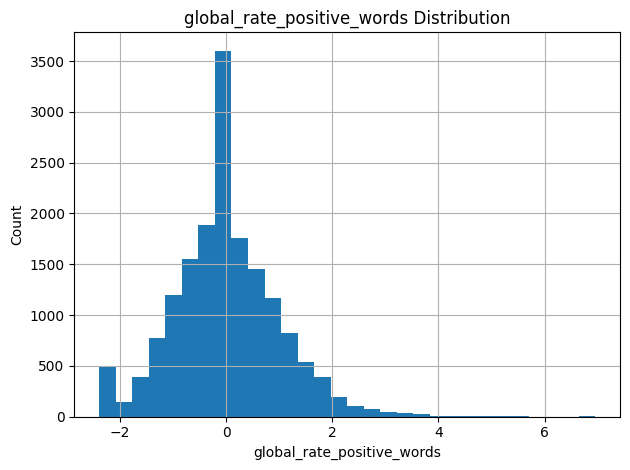

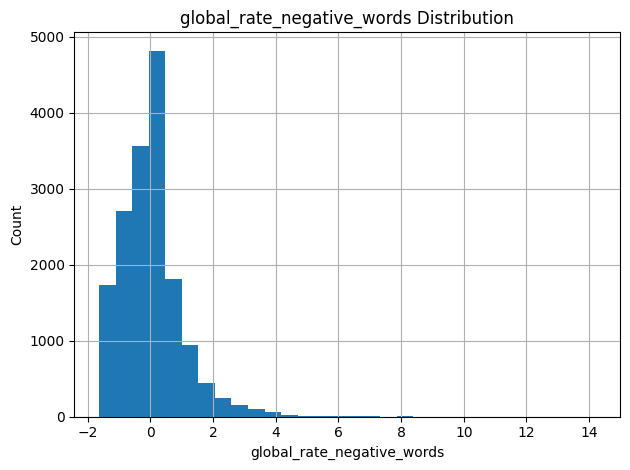

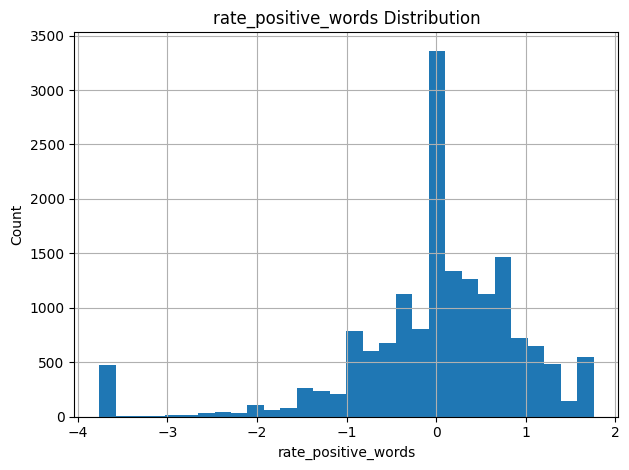

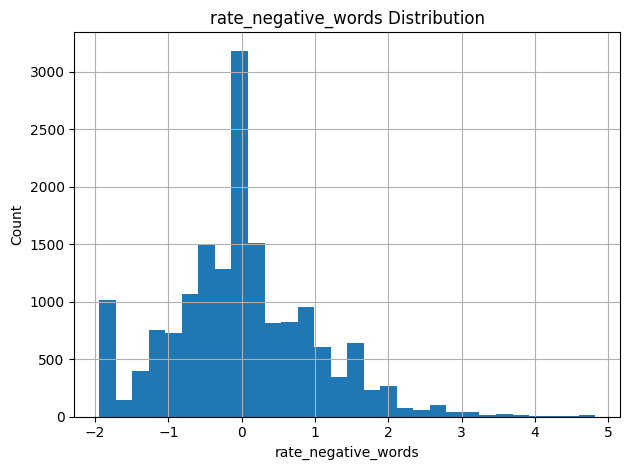

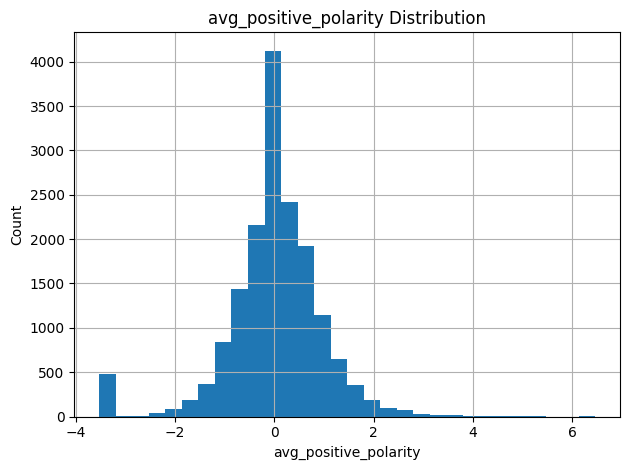

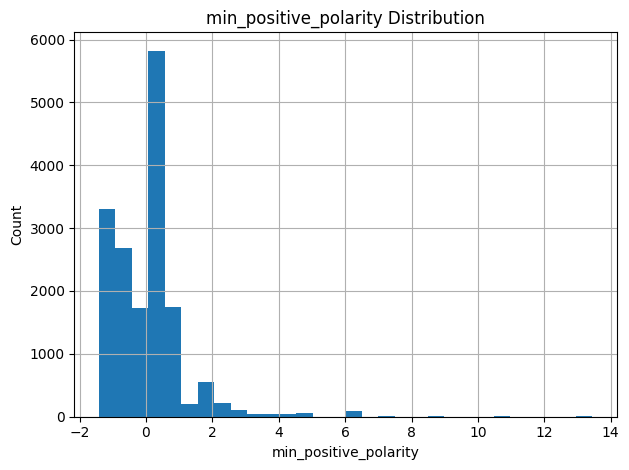

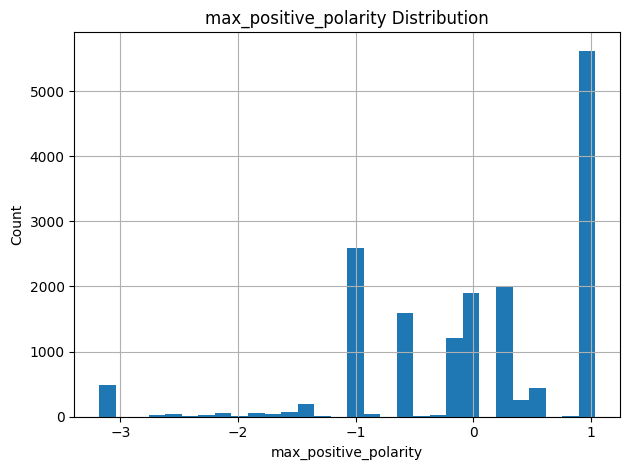

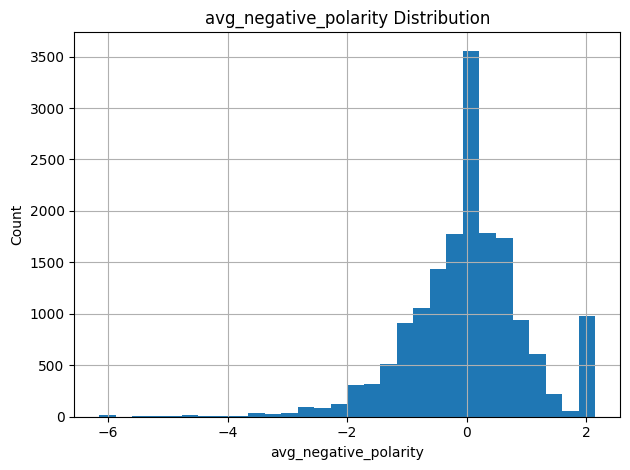

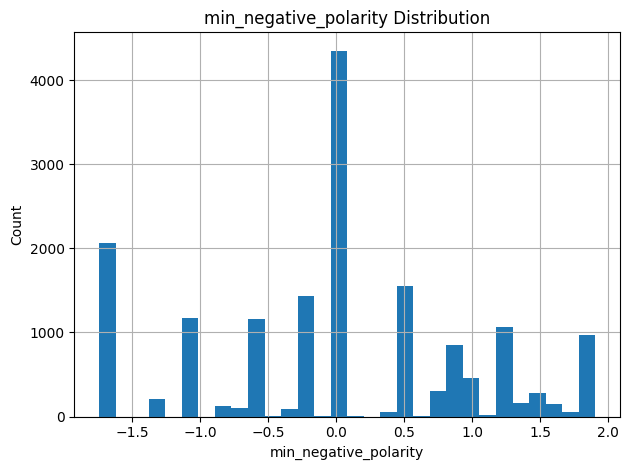

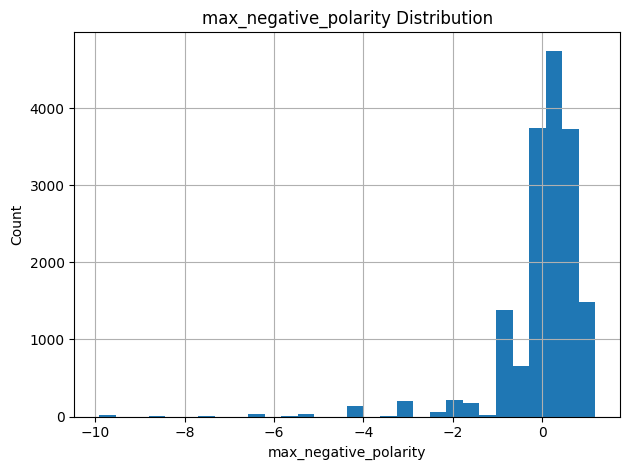

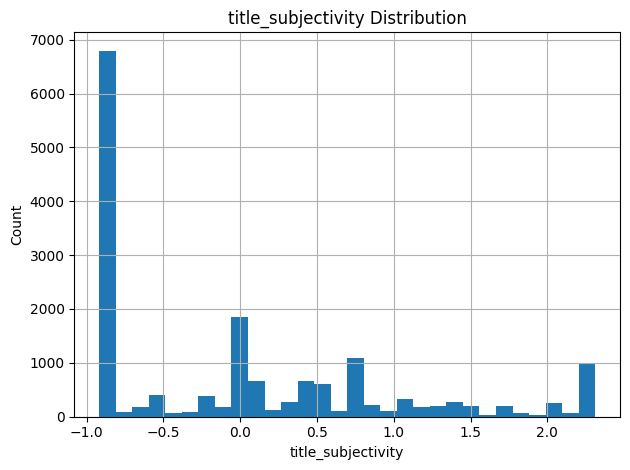

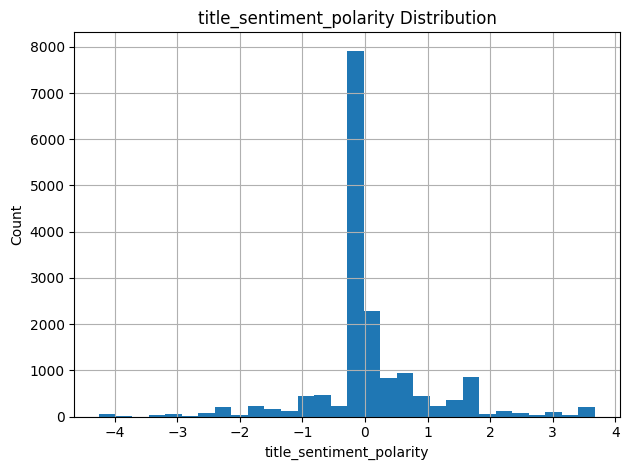

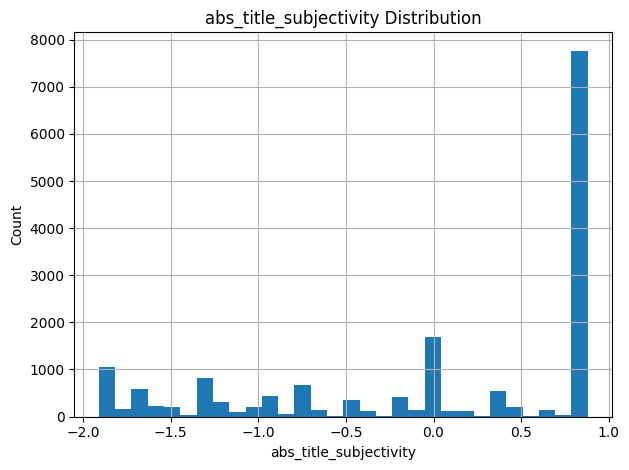

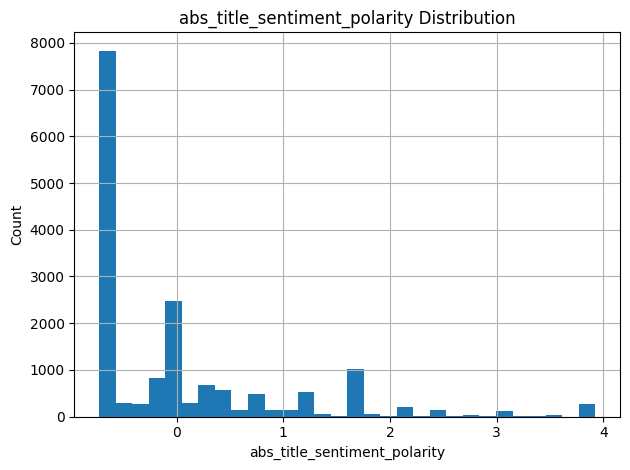

In [14]:
# 수치형 변수 분포 히스토그램
for col in num_features:
    plt.figure()
    df_train_proc[col].hist(bins=30)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()

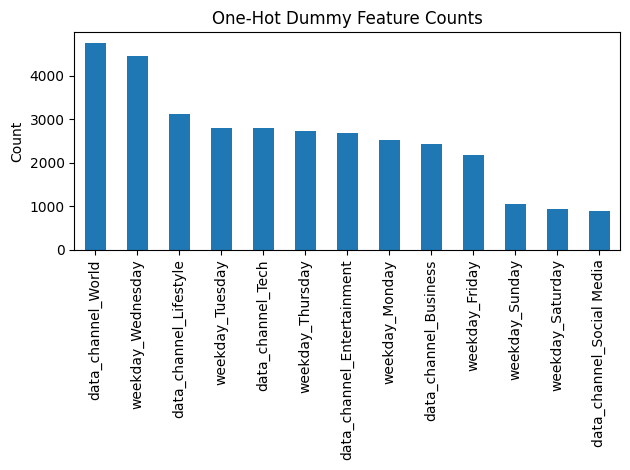

In [15]:
# 범주형 더미 변수 빈도 막대그래프
dummy_counts = df_train_proc[cat_features].sum().sort_values(ascending=False)
plt.figure()
dummy_counts.plot.bar()
plt.title('One-Hot Dummy Feature Counts')
plt.ylabel('Count')
plt.tight_layout()

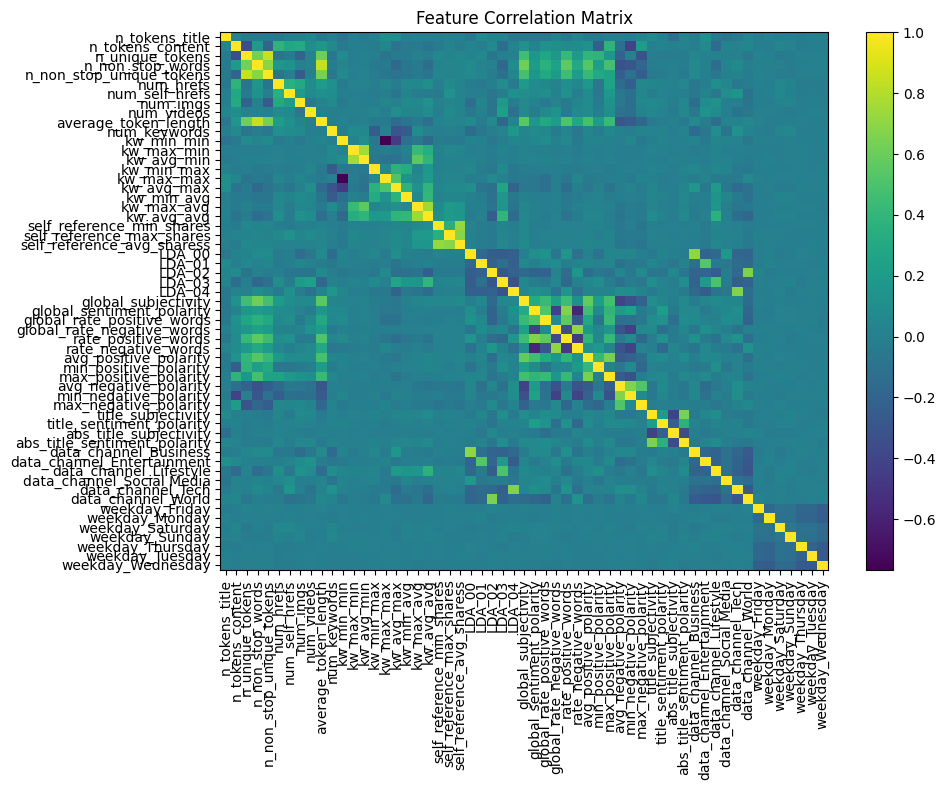

In [16]:
# 피처 간 상관관계 히트맵
corr = df_train_proc.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names)
plt.title('Feature Correlation Matrix')
plt.tight_layout()

In [17]:
# 전처리 전 기준
corr_series = train_df[numerical_cols + ['y']].corr()['y'].abs().sort_values(ascending=False)
print("y와 상관 높은 변수 (원본 기준):\n", corr_series[1:6])

y와 상관 높은 변수 (원본 기준):
 kw_avg_avg    0.160963
LDA_02        0.148140
LDA_04        0.089543
kw_min_avg    0.087915
num_hrefs     0.083695
Name: y, dtype: float64


Y에 따른 변수 분포 비교

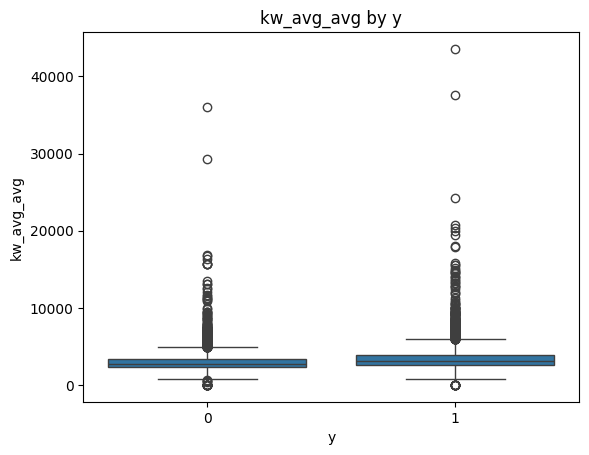

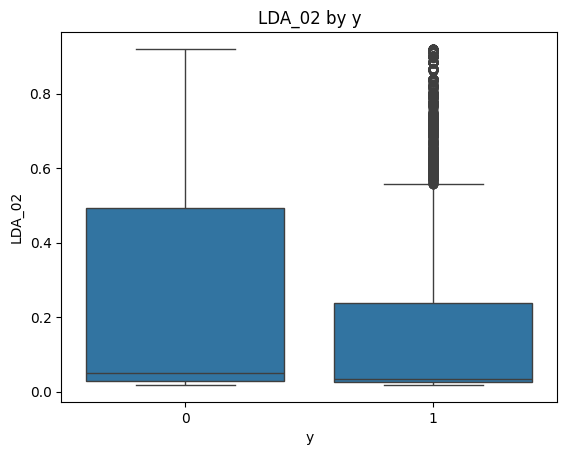

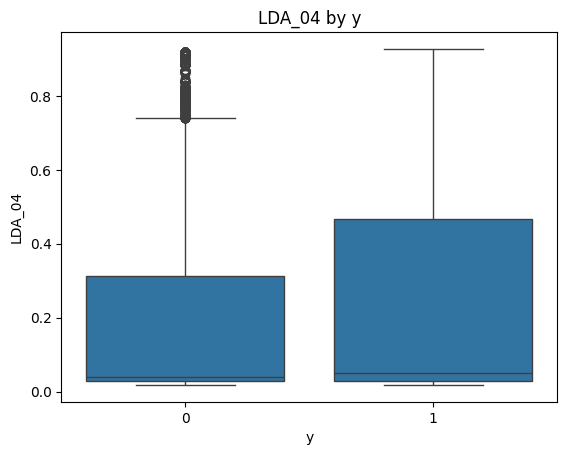

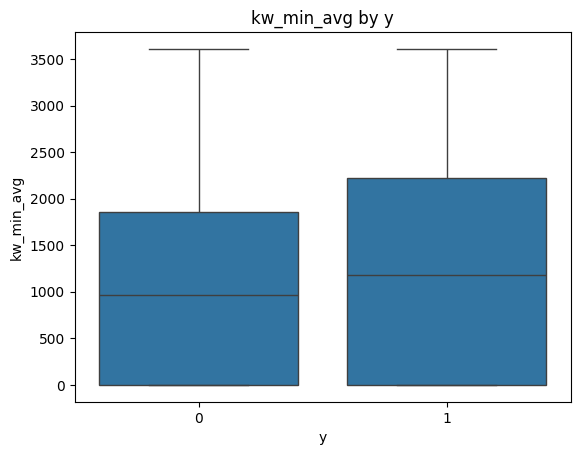

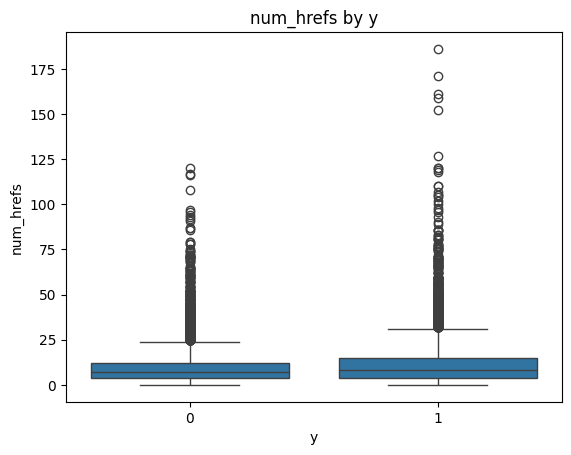

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

important_features = ['kw_avg_avg', 'LDA_02', 'LDA_04', 'kw_min_avg', 'num_hrefs']

for feature in important_features:
    sns.boxplot(x='y', y=feature, data=train_df)
    plt.title(f"{feature} by y")
    plt.show()

lightGBM 모델링

In [19]:
!pip install lightgbm

In [20]:
# 2. 불러오기
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 3. 데이터 불러오기
train = pd.read_csv(root_dir + "/train.csv")
test = pd.read_csv(root_dir + "/test.csv")

# 4. 불필요한 열 제거 및 분리
X = train.drop(columns=["id", "shares", "y"])
y = train["y"]
X_test = test.drop(columns=["id"])

# 5. 범주형 변수 자동 지정
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# 범주형 변수 dtype 변경
for col in categorical_cols:
    X[col] = X[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# 6. train-validation 분리
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
# 7. LightGBM 전용 데이터셋 생성
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=categorical_cols, free_raw_data=False)

# 8. 하이퍼파라미터 설정
params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_pre_filter": False,
    "verbose": -1
}

# 9. 모델 학습
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)  # ← 이게 verbose_eval 역할
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.541707	training's auc: 0.828949	valid_1's binary_logloss: 0.6097	valid_1's auc: 0.72792
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.522432	training's auc: 0.850659	valid_1's binary_logloss: 0.609048	valid_1's auc: 0.728035


In [22]:
# 10. 예측 및 평가
y_pred = model.predict(X_val)
y_bin = (y_pred > 0.5).astype(int)

acc = accuracy_score(y_val, y_bin)
f1 = f1_score(y_val, y_bin)
auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.6651
F1 Score: 0.6610
AUC: 0.7280


파라미터 수정 및 기타 성능 개선

In [23]:
from collections import Counter
neg, pos = Counter(y_train)[0], Counter(y_train)[1]

params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "num_leaves": 64,
    "max_depth": 8,
    "min_data_in_leaf": 30,
    "lambda_l2": 1.0,
    "feature_pre_filter": False,
    "scale_pos_weight": neg / pos,  # ✅ 직접 비율 계산
    "verbosity": -1
}



In [24]:

# 클래스 불균형 비율 확인 후 처리
from collections import Counter
neg, pos = Counter(y_train)[0], Counter(y_train)[1]
params["scale_pos_weight"] = neg / pos


In [25]:
# 데이터 split
X = train_df.drop(columns=['id', 'shares', 'y'])
y = train_df['y']
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# split된 X_train에만 fit_transform
X_train_proc = preprocessor.fit_transform(X_train)
X_holdout_proc = preprocessor.transform(X_holdout)

In [26]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

train_set = lgb.Dataset(X_train_proc, label=y_train)

cv_results = lgb.cv(
    params,
    train_set,
    nfold=5,
    stratified=True,
    num_boost_round=1000,
    metrics='auc',
    seed=42,
    callbacks=[early_stopping(50), log_evaluation(100)]
)

print("Best AUC:", max(cv_results['valid auc-mean']))

Training until validation scores don't improve for 50 rounds
[100]	cv_agg's valid auc: 0.697462 + 0.00519683
[200]	cv_agg's valid auc: 0.705583 + 0.00590973
[300]	cv_agg's valid auc: 0.70749 + 0.00648178
[400]	cv_agg's valid auc: 0.70876 + 0.00687488
[500]	cv_agg's valid auc: 0.709173 + 0.00725316
Early stopping, best iteration is:
[511]	cv_agg's valid auc: 0.709199 + 0.00723339
Best AUC: 0.7091987742230772


Cutoff 튜닝

In [27]:
# 5. LightGBM 파라미터 설정
from collections import Counter
neg, pos = Counter(y_train)[0], Counter(y_train)[1]

params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "num_leaves": 64,
    "max_depth": 8,
    "min_data_in_leaf": 30,
    "lambda_l2": 1.0,
    "feature_pre_filter": False,
    "scale_pos_weight": neg / pos,
    "verbosity": -1
}

# 6. 모델 학습
train_set = lgb.Dataset(X_train_proc, label=y_train)
model = lgb.train(params, train_set, num_boost_round=500)


In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score
# 7. Cutoff 튜닝
y_prob = model.predict(X_holdout_proc)
cutoffs = [0.3, 0.4, 0.5, 0.6, 0.7]

print(" Cutoff별 F1 / Precision / Recall")
best_cutoff, best_f1 = 0.5, 0
for cutoff in cutoffs:
    y_pred = (y_prob > cutoff).astype(int)
    f1 = f1_score(y_holdout, y_pred)
    precision = precision_score(y_holdout, y_pred)
    recall = recall_score(y_holdout, y_pred)

    print(f"Cutoff={cutoff:.2f} → F1={f1:.4f} / Precision={precision:.4f} / Recall={recall:.4f}")
    if f1 > best_f1:
        best_cutoff, best_f1 = cutoff, f1

print(f"\nBest Cutoff = {best_cutoff}, Best F1 = {best_f1:.4f}")

 Cutoff별 F1 / Precision / Recall
Cutoff=0.30 → F1=0.6940 / Precision=0.5536 / Recall=0.9298
Cutoff=0.40 → F1=0.6931 / Precision=0.6012 / Recall=0.8182
Cutoff=0.50 → F1=0.6644 / Precision=0.6661 / Recall=0.6627
Cutoff=0.60 → F1=0.5674 / Precision=0.7244 / Recall=0.4664
Cutoff=0.70 → F1=0.3800 / Precision=0.7942 / Recall=0.2497

Best Cutoff = 0.3, Best F1 = 0.6940
